In [99]:
from continuous_simulations import spread_continuous_rumour
from networkx.classes.graph import Graph
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
from display_simulations import display_simulation

In [100]:
c = 1.5
c_0 = 1/2 + 1/np.exp(1)
C = (10*c + 20)/c_0
C = 1

In [101]:
DEFAULT_MAX_NODES = 300
x = np.linspace(1, DEFAULT_MAX_NODES, 2*DEFAULT_MAX_NODES)

In [102]:
def spreading_scaling_simulation(graph_generator, min_nodes = 10, max_nodes = DEFAULT_MAX_NODES, step = 10, runs_per_size = 10):
    results = []
    means = []
    for n in range(min_nodes, max_nodes+1, step):
        spreading_times = [spread_continuous_rumour(graph_generator, n) for i in range(runs_per_size)]
        # results.append((n, np.median(spreading_times)))
        spreading_time_tuples = [(n, spreading_time) for spreading_time in spreading_times]
        results.extend(spreading_time_tuples)
        means.append((n, np.mean(spreading_times)))
    return results, means

### Ring Graph

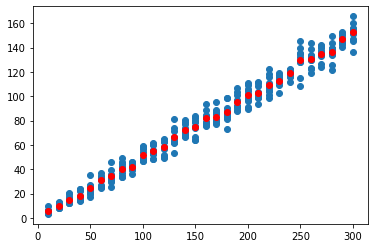

In [103]:
def ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.cycle_graph(number_of_nodes)

results, means = spreading_scaling_simulation(ring_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
# f = C * x * np.log(x) / 2
# plt.plot(x, f, 'r')
plt.show()

### Shuffled Ring Graph

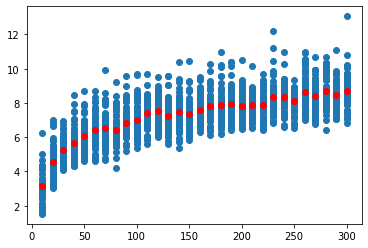

In [104]:
def shuffled_ring_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.cycle_graph(node_permutation)

results, means = spreading_scaling_simulation(shuffled_ring_generator, runs_per_size=50)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Complete Graph

In [110]:
def complete_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    return nx.complete_graph(number_of_nodes)

results, means = spreading_scaling_simulation(complete_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = 2 * C * np.log(x)
plt.plot(x, f, 'g')
plt.show()

KeyboardInterrupt: 

### ER Random Graph

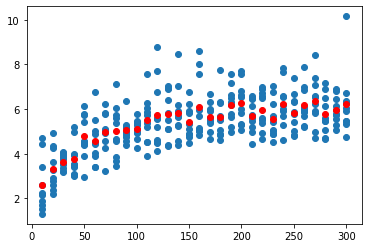

In [106]:
def ER_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    p = 1/np.log(number_of_nodes) # TODO: Check if this works - log log scaling gives same result? seems too fast
    return nx.fast_gnp_random_graph(number_of_nodes, p)

results, means = spreading_scaling_simulation(ER_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()

### Static Star Graph (Initial node not hub)

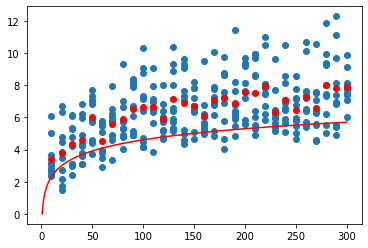

In [107]:
def static_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    # Generates list [1,2, ..., number_of_nodes - 1, 0]
    # First node in list is hub
    nodes = [(i+1) % number_of_nodes for i in range(number_of_nodes)]

    return nx.star_graph(nodes)

results, means = spreading_scaling_simulation(static_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
f = C * np.log(x)
plt.plot(x, f, 'r')
plt.show()

### Shuffled Star Graph

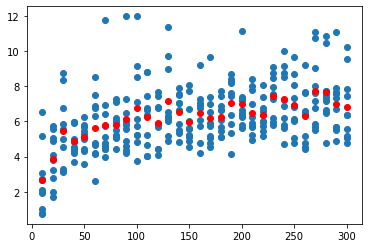

In [108]:
def shuffled_star_generator(number_of_nodes, timestep, informed_nodes) -> Graph:
    node_permutation = np.random.permutation(number_of_nodes)
    return nx.star_graph(node_permutation)

results, means = spreading_scaling_simulation(shuffled_star_generator)

plt.scatter(*zip(*results))
plt.scatter(*zip(*means), c='r')
plt.show()